In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns


%matplotlib inline

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/")

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
class TF_PCA:

    def __init__(self, data, dtype=tf.float32):
        self.data = data
        self.dtype = dtype

        self.graph = None
        self.X = None
        self.u = None
        self.singular_values = None
        self.sigma = None

    def fit(self):
        self.graph = tf.Graph()
        with self.graph.as_default():
            self.X = tf.placeholder(self.dtype, shape=self.data.shape)

            # Perform SVD
            singular_values, u, _ = tf.svd(self.X)

            # Create sigma matrix
            sigma = tf.diag(singular_values)

        with tf.Session(graph=self.graph) as session:
            self.u, self.singular_values, self.sigma = session.run([u, singular_values, sigma],
                                                                   feed_dict={self.X: self.data})

    def reduce(self, n_dimensions=None, keep_info=None):
        if keep_info:
            # Normalize singular values
            normalized_singular_values = self.singular_values / sum(self.singular_values)

            # information per dimension
            info = np.cumsum(normalized_singular_values)
            
           
            # Get the first index which is above the given information threshold
            it = iter(idx for idx, value in enumerate(info) if value >= keep_info)
            n_dimensions = next(it) + 1
            
           
        with self.graph.as_default():
            # Cut out the relevant part from sigma
            sigma = tf.slice(self.sigma, [0, 0], [self.data.shape[1], n_dimensions])

            # PCA
            pca = tf.matmul(self.u, sigma)

        with tf.Session(graph=self.graph) as session:
            return session.run(pca, feed_dict={self.X: self.data})

In [4]:
tf_pca = TF_PCA(mnist.train.images)
tf_pca.fit()
pca = tf_pca.reduce(keep_info=0.1)  # The reduced dimensions dependent upon the % of information
print('original data shape', mnist.train.images.shape)
print('reduced data shape', pca.shape)  


original data shape (55000, 784)
reduced data shape (55000, 3)


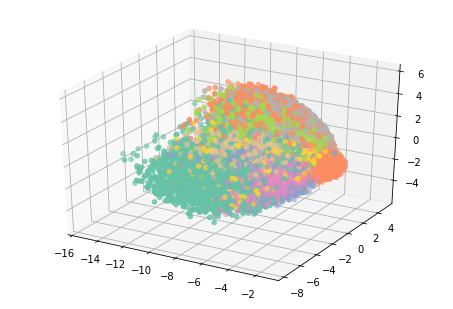

In [5]:
Set = sns.color_palette("Set2", 10)
color_mapping = {key:value for (key,value) in enumerate(Set)}
colors = list(map(lambda x: color_mapping[x], mnist.train.labels))
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(pca[:, 0], pca[:, 1],pca[:, 2], c=colors)
